気象庁のサイト
https://www.data.jma.go.jp/cpdinfo/temp/an_wld.html

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import stan
%matplotlib inline

In [6]:
plt.style.use("ggplot")

In [7]:
df = pd.read_excel("./data/temperature_series.xlsx")

In [8]:
df.head()

,x,y
0,1891,-0.6291
1,1892,-0.7111
2,1893,-0.7520
3,1894,-0.7008
4,1895,-0.6752


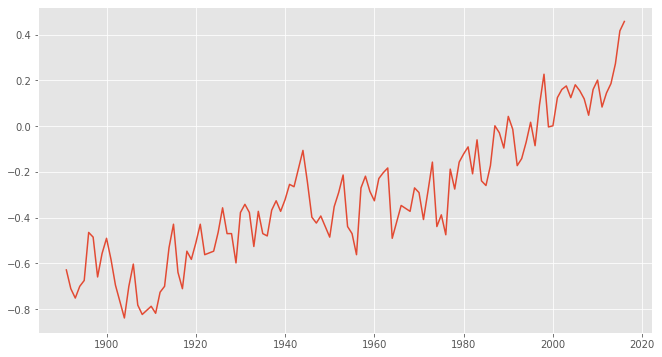

In [29]:
plt.figure(figsize=(11,6))

plt.plot(df["x"],df["y"]);

想定：  
「2016までのデータから2017年を予測する」

In [11]:
stan_model = """
data {
  int T;
  int T_new;
  real Y[T];
}

parameters {
  real mu[T];
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

model {
  for (t in 2:T){
    mu[t] ~ normal(mu[t-1], s_mu);
  }
  
  for (t in 1:T){
    Y[t] ~ normal(mu[t], s_Y);
  }
}

generated quantities {
  real mu_new;
  real Y_new[T+T_new];
  for (t in 1:T){
    Y_new[t] = normal_rng(mu[t], s_Y);
  }
  mu_new = normal_rng(mu[T], s_mu);
  Y_new[T+T_new] = normal_rng(mu_new, s_Y);
}

"""

In [12]:
stan_data = {"T":df.shape[0],"T_new":1,
             "Y":df["y"].values}

In [13]:
# sm = pystan.StanModel(model_code=stan_model)

In [14]:
# fit = sm.sampling(data = stan_data, iter=3000, warmup=1500, seed=123, chains=3)

In [15]:
# fit

In [16]:
import nest_asyncio
nest_asyncio.apply()

In [17]:
posterior = stan.build(stan_model, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:7,
                 from /root/.cache/httpstan/4.7.2/models/oirvatdj/model_oirvatdj.cpp:2:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp: In member function ‘virtual std::vector<std::complex<double> > stan::io::dump::vals_c(const string&) const’:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<double, std::allocator<double> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
  694 |       for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
      |                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<int>::size_


Building: 31.1s, done.Messages from stanc:
Warning in '/tmp/httpstan_pubvtzhx/model_oirvatdj.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_pubvtzhx/model_oirvatdj.stan', line 9, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_pubvtzhx/model_oirvatdj.stan', line 26, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to

In [18]:
fit = posterior.sample(num_chains=3, num_samples=3000, num_warmup=1500, save_warmup=0)

Sampling:   0%
Sampling:   3% (400/13500)
Sampling:   6% (800/13500)
Sampling:   8% (1100/13500)
Sampling:  13% (1700/13500)
Sampling:  17% (2300/13500)
Sampling:  21% (2900/13500)
Sampling:  47% (6400/13500)
Sampling:  73% (9900/13500)
Sampling: 100% (13500/13500)
Sampling: 100% (13500/13500), done.
Messages received during sampling:
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_rxqp1gcz/model_oirvatdj.stan', line 20, column 4 to column 30)
  If this warning occurs sporadically, such as for highly constrai

In [32]:
df_fit = fit.to_frame()
# df_fit.describe().T

In [40]:
fit['Y_new'].shape

(122, 9000)

In [4]:
# fig = fit.plot()

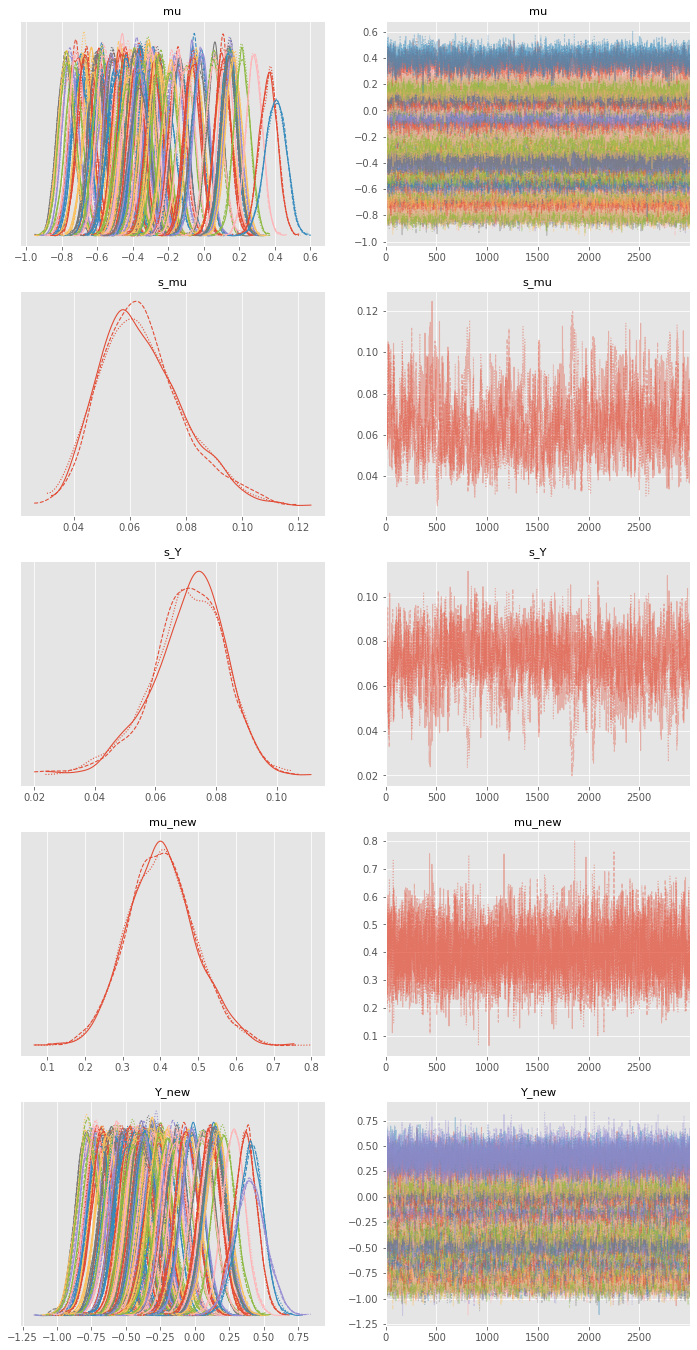

In [22]:
import arviz
arviz.plot_trace(fit, figsize=(12,24));

In [23]:
# Y_new_arr = fit.extract("Y_new")["Y_new"]

Y_new_arr = fit["Y_new"].T

In [24]:
low_y50, high_y50 = mstats.mquantiles(Y_new_arr, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(Y_new_arr, [0.025, 0.975], axis=0)

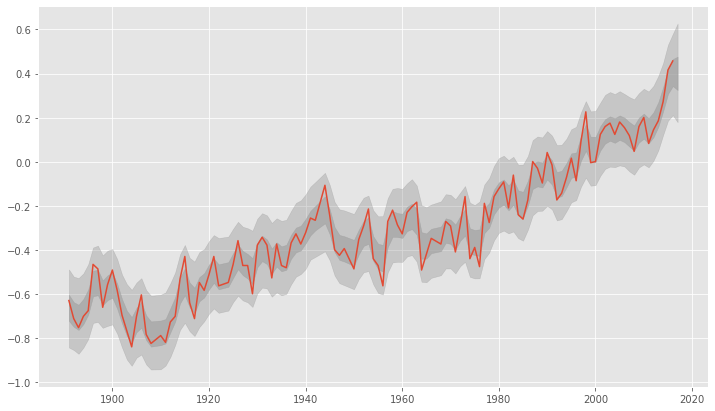

In [28]:
plt.figure(figsize=(12,7))

plt.plot(df["x"],df["y"])
x = df["x"].values
x = np.append(x, 2017)
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")

In [55]:
x.shape

(122,)

In [57]:
Y_new_arr[:,121].mean()

0.4018165766512293